In [1]:
import itertools, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import colors

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *

import evcouplings.couplings

In [2]:
params = np.load('data/Human_9.npz')
hi = params['hi']
Jij = params['Jij']

In [3]:
L, q = hi.shape
L, q

(9, 20)

In [4]:
observables = ['fi', 'fij', 'cij', 'fijk', 'cijk', 'fold_ijk']#, 'fijkl']
observables_dict = {key: dict() for key in observables}
for dataset in ['train', 'test', 'model']:
    params = np.load('data/%s_observables.npz'%dataset)
    for observable in observables:
        observables_dict[observable][dataset] = params[observable]

In [5]:
@numba.jit(nopython=True)
def _flatten_index(i, alpha, q):
    """
    Map position and symbol to index in
    the covariance matrix.
    Parameters
    ----------
    i : int, np.array of int
        The alignment column(s).
    alpha : int, np.array of int
        The symbol(s).
    q : int
        The number of symbols of the
        alphabet used.
    """
    return i * (q - 1) + alpha

In [6]:
@numba.jit(nopython=True)
def reshape_invcov_to_4d(inv_cov_matrix, L, q):
    """
    "Un-flatten" flattened covariance matrix
    
    Parameters
    ----------
    inv_cov_matrix : np.array
        The matrix to be flattened
    L : int
        Model length.
    q : int
        Number of characters in the alphabet.
    Returns
    -------
    np.array
        Matrix of size L x L x
        q x q.
    """
    inv = np.zeros((L, L, q, q))
    for i in range(L):
        for j in range(L):
            for alpha in range(q - 1):
                for beta in range(q - 1):
                    inv[i, j, alpha, beta] = inv_cov_matrix[
                        _flatten_index(i, alpha, q),
                        _flatten_index(j, beta, q)
                    ]
    return inv

In [10]:
def compute_Jij_mf(cij_flat):
    invC = np.linalg.inv(cij_flat)
    Jij = -reshape_invcov_to_4d(invC, L, q)
    return Jij

In [8]:
@numba.jit(nopython=True)
def fields(J_ij, f_i):
    """
    Compute fields in q gauge.
    
    Parameters
    ----------
    J_ij : np.array
        Matrix of size L x L x q x q
        containing coupling parameters.
    f_i : np.array
        Matrix of size L x q
        containing single-site frequencies.
    Returns
    -------
    np.array
        Matrix of size L x q
        containing single-site fields.
    """
    L, q = f_i.shape
    hi = np.zeros((L, q))
    for i in range(L):
        log_fi = np.log(f_i[i] / f_i[i, q-1])
        J_ij_sum = np.zeros((1, q))
        for j in range(L):
            if i != j:
                # some eij values over beta from 1 to q-1
                J_ij_sum += np.dot(J_ij[i, j, :, :q-1], f_i[j, :q-1]).T
        hi[i] = log_fi - J_ij_sum
    return hi

In [11]:
fi = observables_dict['fi']['train']
fij = observables_dict['fij']['train']
alpha = 1e-8
fi_reg = (1-alpha)*fi + alpha/q
fij_reg = (1-alpha)*fij + alpha/q**2
cij_flat = compute_flattened_covariance_matrix(fi_reg, fij_reg)
Jij_mf = compute_Jij_mf(cij_flat)
hi_mf = fields(Jij_mf, fi_reg)

<ipython-input-8-c53c1d109231>:28: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  J_ij_sum += np.dot(J_ij[i, j, :, :q-1], f_i[j, :q-1]).T


In [12]:
def zero_sum_gauge(J_ij):
    J_ij_0 = (J_ij
              - np.mean(J_ij, axis=2)[:, :, np.newaxis, :]
              - np.mean(J_ij, axis=3)[:, :, :, np.newaxis]
              + np.mean(J_ij, axis=(2,3))[:, :, np.newaxis, np.newaxis])
    return J_ij_0

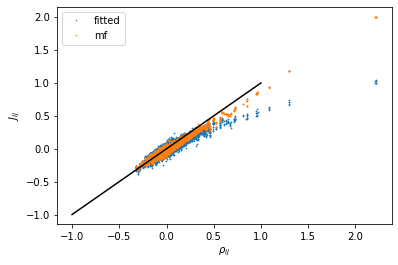

In [13]:
L, q = fi.shape
rhoij = np.zeros(fij.shape)
for i in range(L):
    for j in range(L):
        rhoij[i, j] = fij[i, j]/np.outer(fi[i], fi[j]) - 1.0
plt.plot(flatten_ij(rhoij), flatten_ij(zero_sum_gauge(Jij)),
         '.', ms=1, label='fitted')
plt.plot(flatten_ij(rhoij), flatten_ij(zero_sum_gauge(Jij_mf)),
         '.', ms=1, label='mf')
lim = 1.0
plt.plot([-lim, lim], [-lim, lim], 'k-')
plt.xlabel(r'$\rho_{ij}$')
plt.ylabel('$J_{ij}$')
plt.legend()

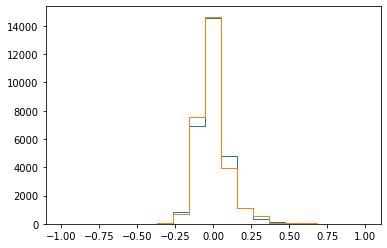

In [15]:
bins = np.linspace(-1, 1, 20)
plt.hist(flatten_ij(zero_sum_gauge(Jij)), bins=bins, histtype='step')
plt.hist(flatten_ij(zero_sum_gauge(Jij_mf)), bins=bins, histtype='step');

In [16]:
Jij_mf_zero = zero_sum_gauge(Jij_mf)
hi_mf_zero = fields(Jij_mf_zero, fi)

In [17]:
prng = np.random
jump = lambda x: local_jump(x, q)
x0 = prng.randint(q, size=L)
sample_matrix = mcmcsampler(x0, lambda x: energy_potts(x, hi_mf, Jij_mf), jump, 1e6, nsample=100, nburnin=1e4)

In [18]:
fi_mf = frequencies(sample_matrix, num_symbols=q)
fij_mf = pair_frequencies(sample_matrix, num_symbols=q, fi=fi_mf)
cij_mf = compute_covariance_matrix(fi_mf, fij_mf)

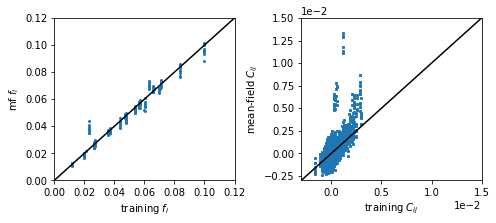

In [33]:
fig, axes = plt.subplots(figsize=(7, 3.2), ncols=2)

ax = axes[0]
lims = [0, 0.12]
ax.plot(np.ravel(fi), np.ravel(fi_mf), 'o', ms=2)
ax.set_xlabel('training $f_i$')
ax.set_ylabel('mf $f_i$')
ax.plot(lims, lims, 'k')
ax.set_xlim(*lims)
ax.set_ylim(*lims)

ax = axes[1]
lims = [-0.3e-2, 1.5e-2]
ax.plot(flatten_ij(observables_dict['cij']['train']), flatten_ij(cij_mf), 'o', ms=2)
ax.set_ylabel('mean-field $C_{ij}$')
ax.set_xlabel('training $C_{ij}$')
ax.plot(lims, lims, 'k')
ax.set_xlim(*lims)
ax.set_ylim(*lims)
ax.ticklabel_format(style='sci', scilimits=(0,0))

fig.tight_layout()
fig.savefig('meanfield.png')

In [21]:
invC = np.linalg.inv(cij_flat)
invC4d = reshape_invcov_to_4d(invC, L, q)
Jij_TAP = -2*invC4d/(1+(1-8*invC4d*fi[:, np.newaxis, :, np.newaxis]*fi[np.newaxis, :, np.newaxis, :])**.5)

/home/amayer/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
flatten_ij(Jij_TAP).mean(), flatten_ij(Jij_mf).mean()

(0.19261893913664105, 0.1930600243824052)

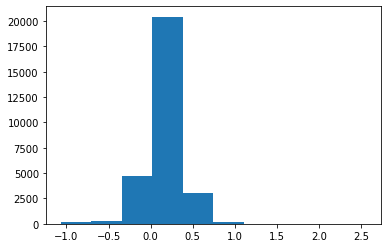

In [23]:
plt.hist(flatten_ij(Jij_TAP));

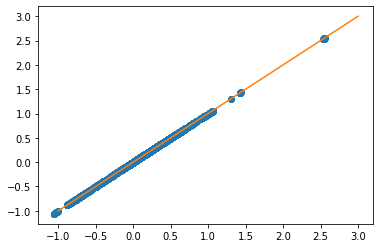

In [24]:
plt.plot(flatten_ij(Jij_mf), flatten_ij(Jij_TAP), 'o')
plt.plot([-1, 3], [-1, 3])

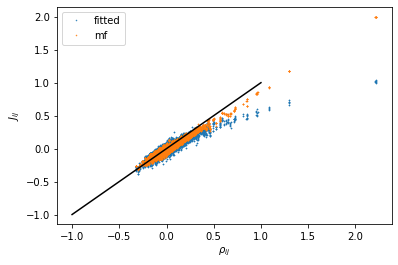

In [25]:
L, q = fi.shape
rhoij = np.zeros(fij.shape)
for i in range(L):
    for j in range(L):
        rhoij[i, j] = fij[i, j]/np.outer(fi[i], fi[j]) - 1.0
plt.plot(flatten_ij(rhoij), flatten_ij(zero_sum_gauge(Jij)),
         '.', ms=1, label='fitted')
plt.plot(flatten_ij(rhoij), flatten_ij(zero_sum_gauge(Jij_TAP)),
         '.', ms=1, label='mf')
lim = 1.0
plt.plot([-lim, lim], [-lim, lim], 'k-')
plt.xlabel(r'$\rho_{ij}$')
plt.ylabel('$J_{ij}$')
plt.legend()